In [1]:
from __future__ import print_function

import math

from IPython import display
from matplotlib import cm
from matplotlib import gridspec
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
from sklearn import metrics
from sklearn.utils import shuffle
import tensorflow as tf
from tensorflow.python.data import Dataset

tf.logging.set_verbosity(tf.logging.ERROR)
pd.options.display.max_rows = 10
pd.options.display.float_format = '{:.1f}'.format


/home/erich/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/erich/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/erich/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/erich/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.

In [2]:
housing_df = pd.read_csv('/home/erich/Downloads/Exercises/train_LR.csv', sep=",")
# randomize the data -- order may cause issues
housing_df = shuffle(housing_df)

In [4]:
processed_features = housing_df[['GrLivArea']]

output_targets = housing_df[['SalePrice']]

In [5]:
training_examples = processed_features[0:1060]
training_targets = output_targets[0:1060]

val_examples = processed_features[1060:1260]
val_targets = output_targets[1060:1260]

test_examples = processed_features[1260:1460]
test_targets = output_targets[1260:1460]

In [19]:
# configure a numeric feature column for GrLivArea
my_feature_columns = [tf.feature_column.numeric_column("GrLivArea")]

# Define the preferred optimizer; in this case lets use gradient descent
my_optimizer = tf.train.GradientDescentOptimizer(learning_rate=0.1)
my_optimizer = tf.contrib.estimator.clip_gradients_by_norm(my_optimizer, 5.0)

# configure the linear regression model with out feature columns and optimizer
model = tf.estimator.LinearRegressor(feature_columns=my_feature_columns, optimizer=my_optimizer)


In [20]:
def my_input_fn(features, targets, batch_size=1, shuffle=True, num_epochs=None):
    # Convert pandas data into a dict of np arrays.
    features = {key:np.array(value) for key, value in dict(features).items()}
    
    # Construct a dataset, and confiture batching/repeating
    ds = Dataset.from_tensor_slices((features, targets)) # warning: 2GB limit
    ds = ds.batch(batch_size).repeat(num_epochs)
    
    # Shuffle the data if specified
    if shuffle:
        ds = ds.shuffle(buffer_size=10000)
        
    # return the next batch of data
    features, labels = ds.make_one_shot_iterator().get_next()
    
    return features, labels

In [21]:
# train the model from the existing data
training = model.train(input_fn = lambda:my_input_fn(training_examples, training_targets), steps=1000)

In [24]:
# RMSE
train_predictions = model.predict(input_fn=lambda: my_input_fn(training_examples, training_targets, num_epochs=1, shuffle=False))
val_predictions = model.predict(input_fn=lambda: my_input_fn(val_examples, val_targets, num_epochs=1, shuffle=False))
test_predictions = model.predict(input_fn=lambda: my_input_fn(test_examples, test_targets, num_epochs=1, shuffle=False))

train_predictions = np.array([item['predictions'][0] for item in train_predictions])
val_predictions = np.array([item['predictions'][0] for item in val_predictions])
test_predictions = np.array([item['predictions'][0] for item in test_predictions])

mean_squared_error = metrics.mean_squared_error(train_predictions, training_targets)
root_mean_squared_error = math.sqrt(mean_squared_error)
print("Root Mean Squared Error (on training data): %0.3f" % root_mean_squared_error)
mean_squared_error = metrics.mean_squared_error(val_predictions, val_targets)
root_mean_squared_error = math.sqrt(mean_squared_error)
print("Root Mean Squared Error (on validation data): %0.3f" % root_mean_squared_error)
mean_squared_error = metrics.mean_squared_error(test_predictions, test_targets)
root_mean_squared_error = math.sqrt(mean_squared_error)
print("Root Mean Squared Error (on test data): %0.3f" % root_mean_squared_error)

Root Mean Squared Error (on training data): 55734.627
Root Mean Squared Error (on validation data): 61010.836
Root Mean Squared Error (on test data): 58834.434


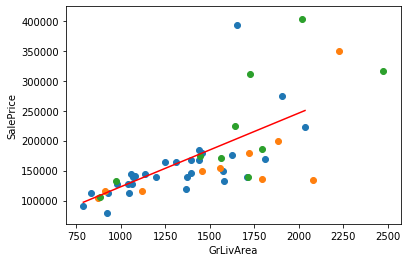

In [25]:
# evaluating the model w/ visuals
train_sample = housing_df[0:1060].sample(30)
val_sample = housing_df[1060:1260].sample(10)
test_sample = housing_df[1260:1460].sample(10)

# get the min and max total_rooms values.
x_0 = train_sample['GrLivArea'].min()
x_1 = train_sample['GrLivArea'].max()

# retrieve the final weight and bias generated during training
weight = model.get_variable_value('linear/linear_model/GrLivArea/weights')[0]
bias = model.get_variable_value('linear/linear_model/bias_weights')

# get the predicted median_house_values for the min and max total_rooms values
y_0 = weight * x_0 + bias
y_1 = weight * x_1 + bias

# plot our regression line from (x_0, y_0) to (x_1, y_1)
plt.plot([x_0, x_1], [y_0, y_1], c='r')

# label the graph axes
plt.ylabel("SalePrice")
plt.xlabel("GrLivArea")

# plot a scatter plot from our data sample
plt.scatter(train_sample['GrLivArea'], train_sample['SalePrice'])
plt.scatter(val_sample['GrLivArea'], val_sample['SalePrice'])
plt.scatter(test_sample['GrLivArea'], test_sample['SalePrice'])

# display graph
plt.show()